# L.point PROJECT

<font color = "#CC3D3D"><p>
- [Basic Settings](#Basic-Settings)
- [Data Collection](#Data-Collection)
- [Data Cleansing](#Data-Cleansing)
    - [Online Missing Value](#Online-Missing-Value)
    - [Offline Missing Value](#Offline-Missing-Value)
    - [Online Outlier](#Online-Outlier)
    - [Offline Outlier](#Offline-Outlier)
- [RFM Analysis](#RFM-Analysis)
    - [Online RFM Analysis](#Online-RFM-Analysis)
    - [Offline RFM Analysis](#Offline-RFM-Analysis)
- [Feature Generation](#Feature-Generation)
    - [Online Feature Generation](#Online-Feature-Generation)
    - [Online Feature Selection](#Online-Feature-Selection)
    - [Offline Feature Generation](#Offline-Feature-Generation)
    - [Offline Feature Selection](#Offline-Feature-Selection)
- [Cluster Analysis](#Cluster-Analysis)
    - [Online Cluster Analysis](#Online-Cluster-Analysis)
    - [Offline Cluster Analysis](#Offline-Cluster-Analysis)
- [Market Basket Analysis](#Market-Basket-Analysis)
    - [Online Basket Analysis](#Online-Basket-Analysis)
    - [Offline Basket Analysis](#Offline-Basket-Analysis)
- [Recommend System](#Recommend-System)
    - [Online Recommend System](#Online-Recommend-System)
    - [Offline Recommend System](#Offline-Recommend-System)

## Basic Settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline
import gc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

pd.set_option('max_columns', 20, 'max_rows', 20)
sns.set_style('whitegrid')

In [2]:
import platform

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)    

## Data Collection

In [3]:
lg = pd.read_csv('L사_로그정보.csv')
cs = pd.read_csv('L사_고객정보.csv')
cs = cs.drop(50578) 

gd = pd.read_csv('L사_상품정보.csv')
tr = pd.read_csv('L사_거래정보.csv')

gd.pd_c = gd.pd_c.astype(str).str.zfill(4) 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64') 

del gd, tr
gc.collect()

df.head()

C:\Users\Administrator\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,104999,3,A03,0182,2019-09-20,12:41,10900,1,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
1,39423,105124,10,A03,0182,2019-09-20,17:26,21800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
2,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
3,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,50,Chilled Foods,Chilled Instant Foods,Chilled Soups
4,18362,50872,3,A03,0182,2019-07-15,09:46,31600,4,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups


In [4]:
df_on = df.query('biz_unit == "A01" or biz_unit == "A02" or biz_unit == "A03"')
df_on = df_on.merge(lg, on=['clnt_id', 'trans_id', 'biz_unit']) # online 고객만 추출해 lg데이터와 병합
df_off = df.query('biz_unit == "B01" or biz_unit == "B02" or biz_unit == "B03"') # offline 고객만 추출

In [30]:
on.apply(lambda x: np.polyfit(range(11), x[1:], 1)[0].round(2), axis=1)

0      -0.22
1      -0.29
2      -0.33
3      -0.74
4      -0.05
        ... 
8829   -0.01
8830   -0.02
8831    0.03
8832    0.03
8833    0.03
Length: 8834, dtype: float64

In [5]:
df_off = df.query('biz_unit == "B01" or biz_unit == "B02" or biz_unit == "B03"') # offline 고객만 추출

## Data Cleansing

### Online Missing Value

In [15]:
print(df_on.isnull().sum())
del df_on['sech_kwd'] # 모든 값이 널 값이라 열 자체를 삭제
del df_on['dvc_ctg_nm'] # 전체의 70% 이상이 널 값이라 열 자체를 삭제 

clnt_id                 0
trans_id                0
trans_seq               0
biz_unit                0
pd_c                    0
                    ...  
sech_kwd           123078
tot_pag_view_ct         0
tot_sess_hr_v         295
trfc_src                0
dvc_ctg_nm          88145
Length: 25, dtype: int64


In [16]:
df_on = df_on.dropna() # 그 외 결측값이 있는 행 삭제
df_on.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,...,clac_nm3,sess_id,hit_seq,action_type,sess_dt,hit_tm,hit_pss_tm,tot_pag_view_ct,tot_sess_hr_v,trfc_src
0,39423,89469,2,A03,0182,2019-09-01,03:32,25800,2,F,...,Chilled Soups,44,7,6,20190901,03:32,379486,18.0,393.0,PUSH
1,39423,88436,1,A03,0182,2019-08-30,17:15,25800,2,F,...,Chilled Soups,38,34,6,20190830,17:15,2016226,62.0,2132.0,PUSH
2,39423,88436,3,A03,0347,2019-08-30,17:15,2900,2,F,...,Fresh Milk,38,34,6,20190830,17:15,2016226,62.0,2132.0,PUSH
3,39423,88436,9,A03,0519,2019-08-30,17:15,3800,1,F,...,Frozen Korean Soups,38,34,6,20190830,17:15,2016226,62.0,2132.0,PUSH
4,39423,88436,10,A03,1580,2019-08-30,17:15,4990,1,F,...,Garlic,38,34,6,20190830,17:15,2016226,62.0,2132.0,PUSH


### Offline Missing Value

In [17]:
df_off = df_off.dropna() # 결측값이 있는 행 삭제
df_off.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
66,34516,19390,3,B02,0182,2019-08-06,15:15,6990,1,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups
81,28454,24918,8,B02,0182,2019-07-15,21:12,3800,1,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups
82,28454,12511,5,B02,0182,2019-09-27,21:54,6990,1,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups
83,28454,25008,21,B02,0182,2019-08-31,21:51,6990,1,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups
109,25782,28209,5,B02,0182,2019-09-01,22:31,6990,1,F,40,Chilled Foods,Chilled Instant Foods,Chilled Soups


### Online Outlier

In [18]:
print(df_on.query('buy_am != 0 and buy_ct == 0').shape[0])
df_on['buy_ct'] = np.where(df_on.buy_ct == 0, 1, df_on.buy_ct) # buy_am가 0이 아닌 경우 buy_ct를 1로 치환 (없음)

print(df_on.query('buy_am == 0').shape[0])
df_on = df_on.query('buy_am != 0') # buy_am이 0인 값은 제거

0
277


2


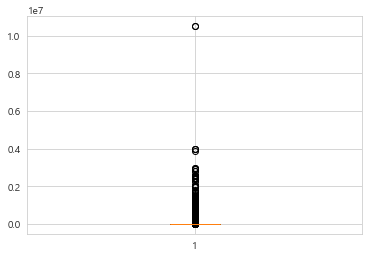

In [19]:
plt.boxplot(df_on['buy_am'])
print(df_on.query('buy_am > 0.8 * 10**7').trans_id.nunique())
df_on = df_on.query('buy_am < 0.8 * 10**7') # buy_am이 특별히 큰 2개의 데이터의 이상치 제거

### Offline Outlier

In [20]:
print(df_off.query('buy_am != 0 and buy_ct == 0').shape[0])
df_off['buy_ct'] = np.where(df_off.buy_ct == 0, 1, df_off.buy_ct) # buy_am가 0이 아닌 경우 buy_ct를 1로 치환

print(df_off.query('buy_am == 0').shape[0]) 
df_off = df_on.query('buy_am != 0') # buy_am이 0인 값은 제거 (없음)

6244
0


0


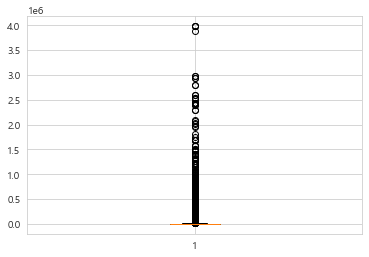

In [21]:
plt.boxplot(df_off['buy_am'])
print(df_off.query('buy_am > 0.8 * 10**7').trans_id.nunique())
df_off = df_off.query('buy_am < 0.8 * 10**7') # buy_am이 특별히 큰 2개의 데이터의 이상치 제거

In [22]:
# 데이터 요약
print('=======  분석 데이터 요약  =======')
print('▶ 고객수:', df.clnt_id.nunique())
print(f'▶ 상품수: 대분류({df.clac_nm1.nunique()}), 중분류({df.clac_nm2.nunique()}), 소분류({df.clac_nm3.nunique()})')
print('▶ 업종수:', df.biz_unit.nunique())
print(f'▶ 기간: {df.de_dt.min()} ~ {df.de_dt.max()} ({(df.de_dt.max()-df.de_dt.min()).days+1}일)')

=======  분석 데이터 요약  =======
▶ 고객수: 11270
▶ 상품수: 대분류(60), 중분류(332), 소분류(1661)
▶ 업종수: 6
▶ 기간: 2019-07-01 00:00:00 ~ 2019-09-30 00:00:00 (92일)


## RFM Analysis

### Online RFM Analysis

#### Recency value

In [14]:
now = df_on.de_dt.max() + pd.DateOffset(days=1)

recency_on = (df_on.groupby('clnt_id')['de_dt']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'recency'})
          )
recency_on

,clnt_id,recency
0,2,32
1,9,27
2,23,73
3,24,28
4,38,51
...,...,...
8829,72373,15
8830,72400,62
8831,72410,67
8832,72423,14


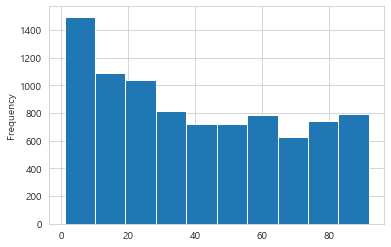

In [15]:
recency_on.recency.plot.hist()
plt.show()

#### Frequency value

In [16]:
frequency_on =  df_on.groupby('clnt_id')['trans_id'].agg([('frequency', np.size)]).reset_index()
frequency_on

,clnt_id,frequency
0,2,10
1,9,17
2,23,1
3,24,16
4,38,5
...,...,...
8829,72373,8
8830,72400,3
8831,72410,1
8832,72423,1


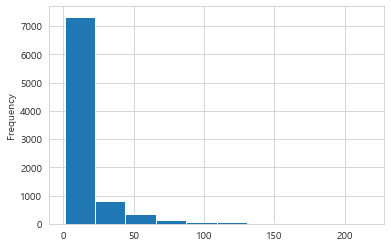

In [17]:
frequency_on.frequency.plot.hist()
plt.show()

#### Monetary value

In [18]:
monetary_on = df_on.groupby('clnt_id')['buy_am'].agg([('monetary', np.sum)]).reset_index()
monetary_on

,clnt_id,monetary
0,2,75700
1,9,59930
2,23,27000
3,24,109590
4,38,76865
...,...,...
8829,72373,888360
8830,72400,138900
8831,72410,14470
8832,72423,479700


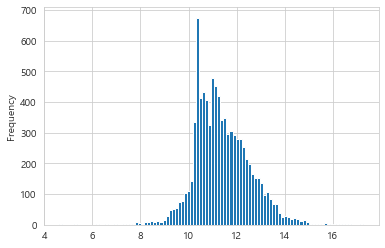

In [19]:
monetary_on.monetary.apply(lambda x : np.log1p(x)).plot.hist(bins=100)
plt.show()

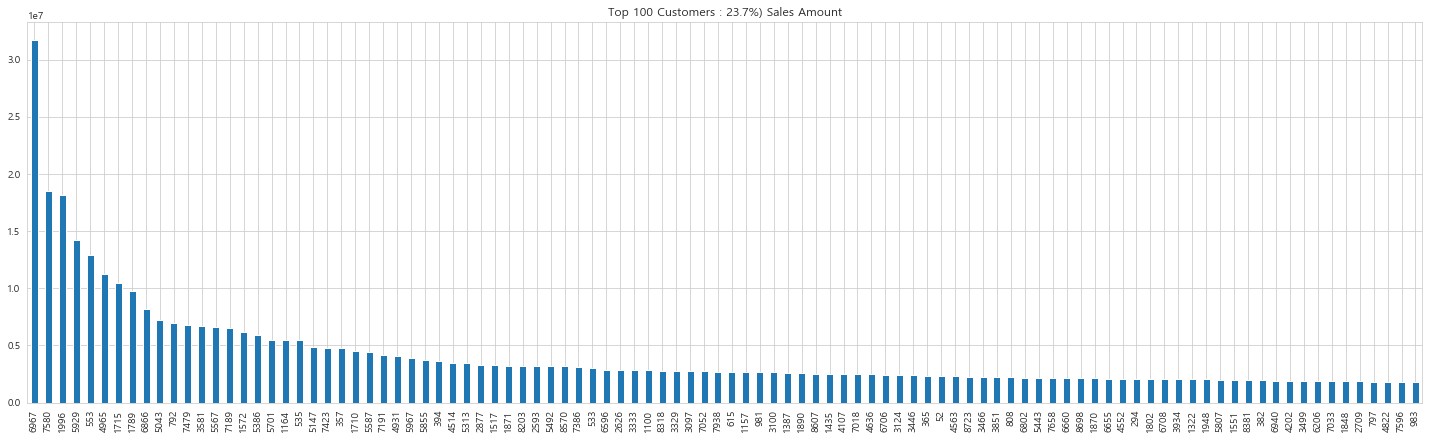

In [20]:
plt.figure(figsize=(25, 7))
top_n = 100 # 상위 1%가 전체의 20%
 
percent_sales = (monetary_on.monetary.sort_values(ascending=False) \
                 .iloc[:top_n].sum() / monetary_on.monetary.sum()).round(3)

monetary_on.monetary.sort_values(ascending=False) \
                .iloc[:top_n].plot.bar(title = f'Top {top_n} Customers : {percent_sales:.1%}) Sales Amount')

plt.show()           

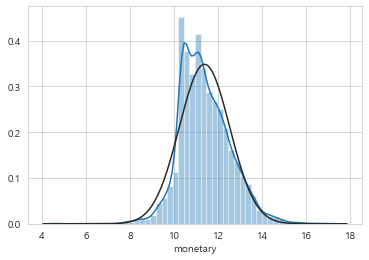

In [21]:
from scipy.stats import norm
sns.distplot(monetary_on.monetary.apply(lambda x : np.log1p(x)), fit=norm) 

#### RFM score

In [22]:
rfm_on = recency_on.merge(frequency_on).merge(monetary_on)
rfm_on

,clnt_id,recency,frequency,monetary
0,2,32,10,75700
1,9,27,17,59930
2,23,73,1,27000
3,24,28,16,109590
4,38,51,5,76865
...,...,...,...,...
8829,72373,15,8,888360
8830,72400,62,3,138900
8831,72410,67,1,14470
8832,72423,14,1,479700


In [23]:
rfm_on['R'] = pd.qcut(rfm_on['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm_on['F'] = pd.qcut(rfm_on['frequency'], q=3, labels=range(1,4)).astype(int) # frequency값을 3개로 나누는 것이 가장 적합!
rfm_on['M'] = pd.qcut(rfm_on['monetary'], q=5, labels=range(1,6)).astype(int)
rfm_on

,clnt_id,recency,frequency,monetary,R,F,M
0,2,32,10,75700,3,2,3
1,9,27,17,59930,4,3,3
2,23,73,1,27000,1,1,1
3,24,28,16,109590,4,3,4
4,38,51,5,76865,2,2,3
...,...,...,...,...,...,...,...
8829,72373,15,8,888360,4,2,5
8830,72400,62,3,138900,2,2,4
8831,72410,67,1,14470,2,1,1
8832,72423,14,1,479700,4,1,5


In [24]:
rfm_on['RFMgroup'] = rfm_on['R'].map(str) + rfm_on['F'].map(str) + rfm_on['M'].map(str)
rfm_on

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup
0,2,32,10,75700,3,2,3,323
1,9,27,17,59930,4,3,3,433
2,23,73,1,27000,1,1,1,111
3,24,28,16,109590,4,3,4,434
4,38,51,5,76865,2,2,3,223
...,...,...,...,...,...,...,...,...
8829,72373,15,8,888360,4,2,5,425
8830,72400,62,3,138900,2,2,4,224
8831,72410,67,1,14470,2,1,1,211
8832,72423,14,1,479700,4,1,5,415


In [25]:
weights = [15, 35, 50] # 여러 논문 자료 참고 결과 대중적인 가중치 적용
rfm_on['RFMscore'] = weights[0] * rfm_on['R'] + weights[1] * rfm_on['F'] + weights[2] * rfm_on['M']
rfm_on

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore
0,2,32,10,75700,3,2,3,323,265
1,9,27,17,59930,4,3,3,433,315
2,23,73,1,27000,1,1,1,111,100
3,24,28,16,109590,4,3,4,434,365
4,38,51,5,76865,2,2,3,223,250
...,...,...,...,...,...,...,...,...,...
8829,72373,15,8,888360,4,2,5,425,380
8830,72400,62,3,138900,2,2,4,224,300
8831,72410,67,1,14470,2,1,1,211,115
8832,72423,14,1,479700,4,1,5,415,345


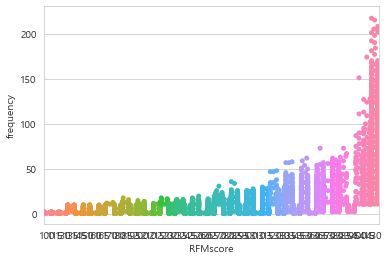

In [26]:
sns.swarmplot(x="RFMscore", y="frequency", data=rfm_on)
plt.show()

### Offline RFM Analysis

#### Recency value

In [27]:
df_off = df.query('biz_unit == "B01" or biz_unit == "B02" or biz_unit == "B03"') # offline 고객만 추출

In [28]:
now = df_off.de_dt.max() + pd.DateOffset(days=1)

recency_off = (df_off.groupby('clnt_id')['de_dt']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'recency'})
          )
recency_off

,clnt_id,recency
0,9,17
1,12,38
2,20,89
3,23,3
4,24,60
...,...,...
7389,72340,19
7390,72356,19
7391,72410,32
7392,72423,43


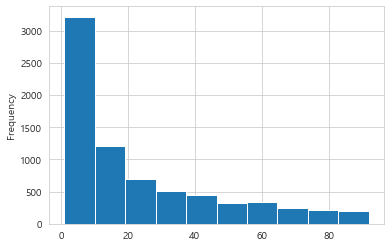

In [29]:
recency_off.recency.plot.hist()
plt.show()

#### Frequency value

In [30]:
frequency_off =  df_off.groupby('clnt_id')['trans_id'].agg([('frequency', np.size)]).reset_index()
frequency_off

,clnt_id,frequency
0,9,22
1,12,1
2,20,1
3,23,49
4,24,1
...,...,...
7389,72340,196
7390,72356,7
7391,72410,45
7392,72423,1


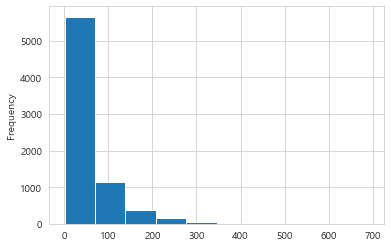

In [31]:
frequency_off.frequency.plot.hist()
plt.show()

#### Monetary value

In [32]:
monetary_off = df_off.groupby('clnt_id')['buy_am'].agg([('monetary', np.sum)]).reset_index()
monetary_off

,clnt_id,monetary
0,9,280011
1,12,29900
2,20,18900
3,23,175964
4,24,2300
...,...,...
7389,72340,705319
7390,72356,73496
7391,72410,149620
7392,72423,19800


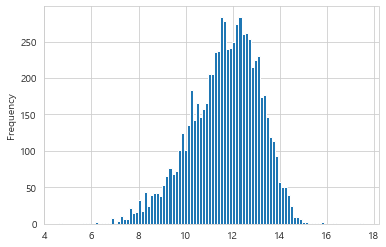

In [33]:
monetary_off.monetary.apply(lambda x : np.log1p(x)).plot.hist(bins=100) 
plt.show() 

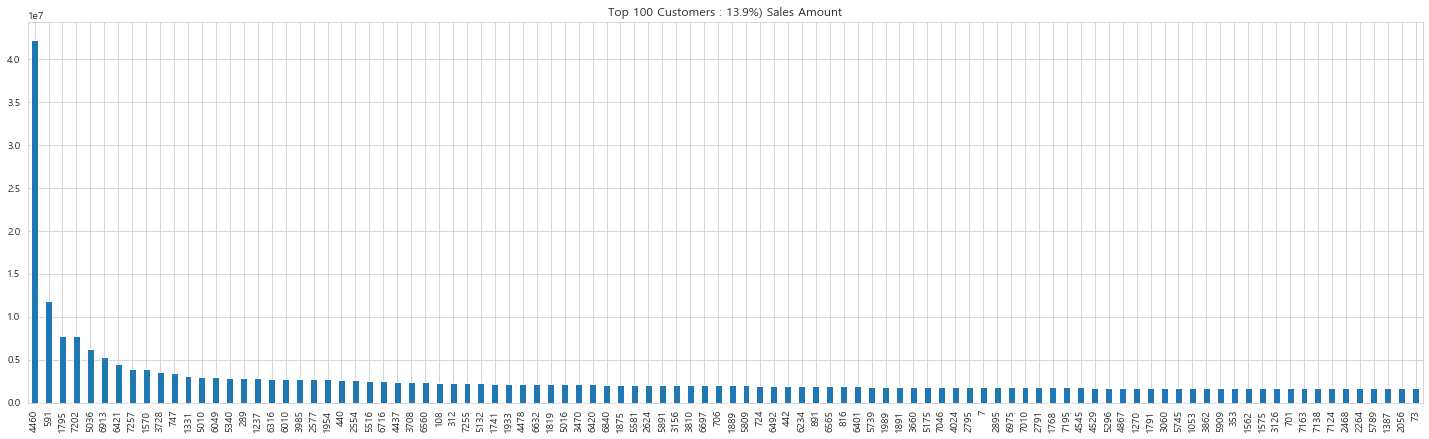

In [34]:
plt.figure(figsize=(25, 7))
top_n = 100 # 상위 1%가 전체의 20%
 
percent_sales = (monetary_off.monetary.sort_values(ascending=False) \
                 .iloc[:top_n].sum() / monetary_off.monetary.sum()).round(3)

monetary_off.monetary.sort_values(ascending=False) \
                .iloc[:top_n].plot.bar(title = f'Top {top_n} Customers : {percent_sales:.1%}) Sales Amount')

plt.show()                                                                     

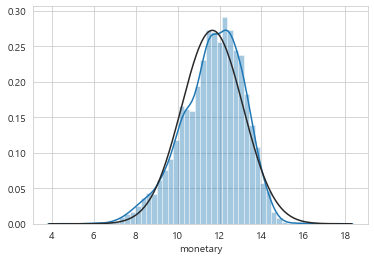

In [35]:
from scipy.stats import norm
sns.distplot(monetary_off.monetary.apply(lambda x : np.log1p(x)), fit=norm) # fit 검정색 -> 정규분포로 바꿈

#### RFM score

In [36]:
rfm_off = recency_off.merge(frequency_off).merge(monetary_off)
rfm_off

,clnt_id,recency,frequency,monetary
0,9,17,22,280011
1,12,38,1,29900
2,20,89,1,18900
3,23,3,49,175964
4,24,60,1,2300
...,...,...,...,...
7389,72340,19,196,705319
7390,72356,19,7,73496
7391,72410,32,45,149620
7392,72423,43,1,19800


In [37]:
rfm_off['R'] = pd.qcut(rfm_off['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm_off['F'] = pd.qcut(rfm_off['frequency'], q=5, labels=range(1,6)).astype(int) 
rfm_off['M'] = pd.qcut(rfm_off['monetary'], q=5, labels=range(1,6)).astype(int)
rfm_off

,clnt_id,recency,frequency,monetary,R,F,M
0,9,17,22,280011,3,3,4
1,12,38,1,29900,2,1,1
2,20,89,1,18900,1,1,1
3,23,3,49,175964,5,4,3
4,24,60,1,2300,1,1,1
...,...,...,...,...,...,...,...
7389,72340,19,196,705319,3,5,5
7390,72356,19,7,73496,3,1,2
7391,72410,32,45,149620,2,4,3
7392,72423,43,1,19800,2,1,1


In [38]:
rfm_off['RFMgroup'] = rfm_off['R'].map(str) + rfm_off['F'].map(str) + rfm_off['M'].map(str)
rfm_off

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup
0,9,17,22,280011,3,3,4,334
1,12,38,1,29900,2,1,1,211
2,20,89,1,18900,1,1,1,111
3,23,3,49,175964,5,4,3,543
4,24,60,1,2300,1,1,1,111
...,...,...,...,...,...,...,...,...
7389,72340,19,196,705319,3,5,5,355
7390,72356,19,7,73496,3,1,2,312
7391,72410,32,45,149620,2,4,3,243
7392,72423,43,1,19800,2,1,1,211


In [39]:
weights = [15, 35, 50] # 여러 논문 자료 참고 결과 대중적인 가중치 적용
rfm_off['RFMscore'] = weights[0] * rfm_off['R'] + weights[1] * rfm_off['F'] + weights[2] * rfm_off['M']
rfm_off

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore
0,9,17,22,280011,3,3,4,334,350
1,12,38,1,29900,2,1,1,211,115
2,20,89,1,18900,1,1,1,111,100
3,23,3,49,175964,5,4,3,543,365
4,24,60,1,2300,1,1,1,111,100
...,...,...,...,...,...,...,...,...,...
7389,72340,19,196,705319,3,5,5,355,470
7390,72356,19,7,73496,3,1,2,312,180
7391,72410,32,45,149620,2,4,3,243,320
7392,72423,43,1,19800,2,1,1,211,115


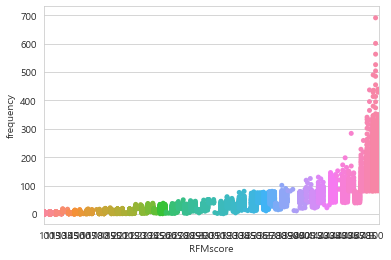

In [40]:
sns.swarmplot(x="RFMscore", y="frequency", data=rfm_off)
plt.show()

## Feature Generation

### Online Feature Generation

In [23]:
features = pd.DataFrame({'clnt_id': df_on.clnt_id.unique()}) ;features

,clnt_id
0,39423
1,48969
2,18478
3,19163
4,48190
...,...
8829,18022
8830,53632
8831,58443
8832,21232


In [42]:
on = df_on.groupby('clnt_id')['buy_am'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(on, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액
0,39423,433032,77,5624,55600
1,48969,267270,69,3873,25800
2,18478,237470,15,15831,65700
3,19163,442090,61,7247,21900
4,48190,149800,21,7133,25800
...,...,...,...,...,...
8829,18022,42000,1,42000,42000
8830,53632,77040,1,77040,77040
8831,58443,568000,1,568000,568000
8832,21232,362500,1,362500,362500


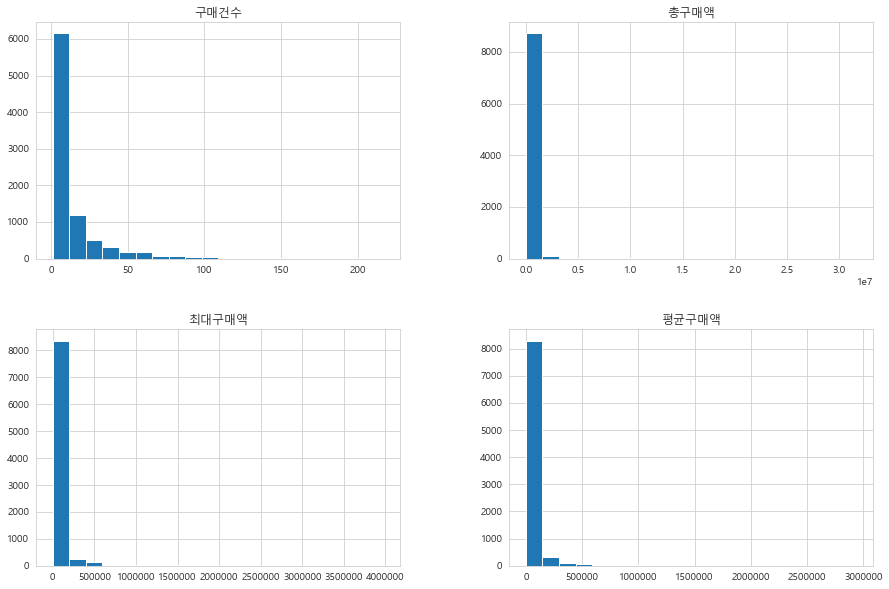

In [43]:
on.iloc[:,1:].hist(bins=20, figsize=(15, 10))
plt.show() 

In [44]:
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [45]:
on = df_on.groupby('clnt_id').agg({
    'clac_nm3': [('구매상품수(소)', lambda x: x.nunique())],
    'clac_nm2': [('구매상품수(중)', lambda x: x.nunique())],
    'clac_nm1': [('구매상품수(대)', lambda x: x.nunique())]
}).reset_index() 
on.columns = drop_column_level(on)
features = features.merge(on, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대)
0,39423,433032,77,5624,55600,42,31,16
1,48969,267270,69,3873,25800,41,28,10
2,18478,237470,15,15831,65700,13,10,8
3,19163,442090,61,7247,21900,44,26,12
4,48190,149800,21,7133,25800,19,15,7
...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1
8830,53632,77040,1,77040,77040,1,1,1
8831,58443,568000,1,568000,568000,1,1,1
8832,21232,362500,1,362500,362500,1,1,1


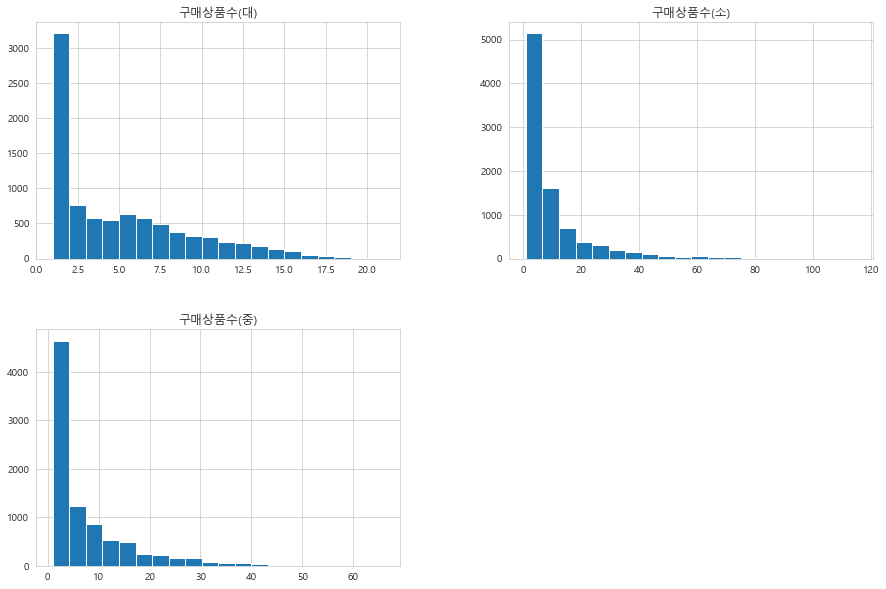

In [46]:
on.iloc[:,1:].hist(bins=20, figsize=(15,10))
plt.show() 

In [47]:
on = df_on.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))
]).reset_index()
features = features.merge(on, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00
...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00


D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


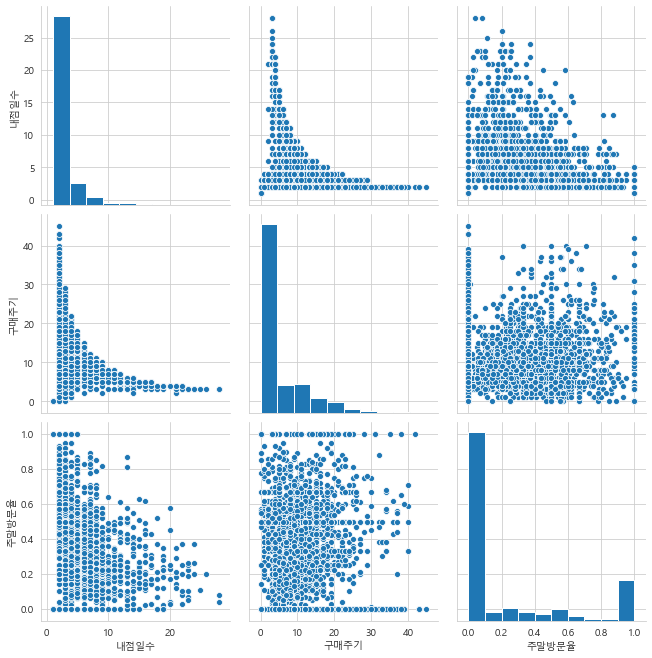

In [48]:
sns.pairplot(data=on.iloc[:,1:], size=3)
plt.show() # 많이 방문할수록 구매주기 작음.

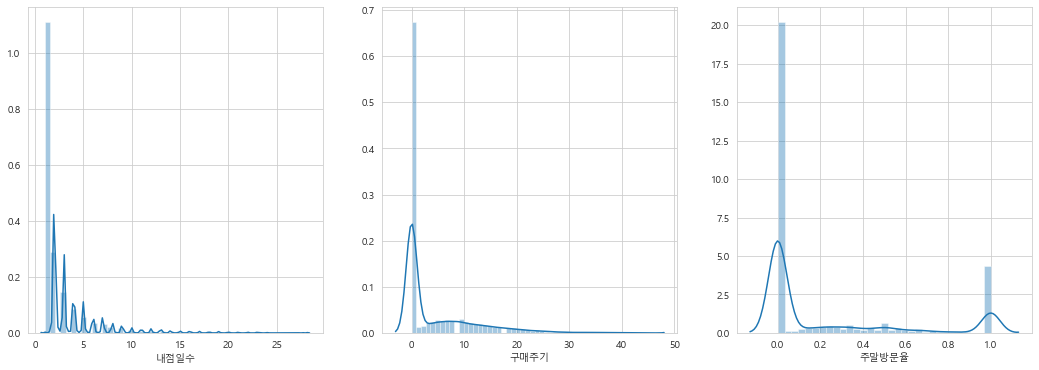

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(18,6)) 
sns.distplot(on.내점일수, ax=ax[0])
sns.distplot(on.구매주기, ax=ax[1])
sns.distplot(on.주말방문율, ax=ax[2])
plt.show()

In [50]:
visit_cnt = df_on.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
per_amount = (df_on.groupby('clnt_id')['buy_am'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (df_on.groupby('clnt_id')['buy_am'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})
on = pd.merge(per_amount, per_count, on='clnt_id')
features = features.merge(on, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0


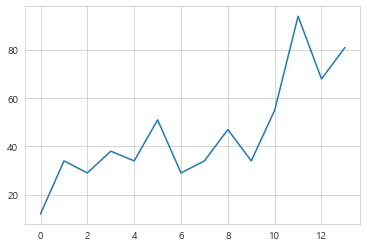

In [51]:
data = [12, 34, 29, 38, 34, 51, 29, 34, 47, 34, 55, 94, 68, 81]
plt.plot(data)
plt.show()

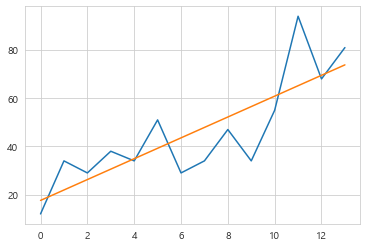

In [52]:
x = np.arange(len(data))
y = np.array(data)
z = np.polyfit(x, y, 1) 
z[0], z[1] 

plt.plot(data)
plt.plot([z[0]*i + z[1] for i in range(len(data))])
plt.show() 

In [53]:
week_to = df_on.de_dt.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < de_dt <= @week_to')
                      .groupby('clnt_id')['trans_id']
                      .agg([(f'w{10-i}', 'count')])
                      .reset_index())
    week_to = week_from

on = pd.DataFrame({'clnt_id': df_on.clnt_id.unique()})
for w in week_trans[::-1]:
    on = pd.merge(on, w, how='left')
on = on.fillna(0)

on['구매추세'] = on.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
features = features.merge(on.iloc[:,[0,-1]], how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9,0.32
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9,0.16
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0,-0.27
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8,-0.04
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0,-0.01
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04


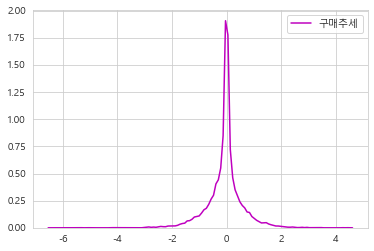

In [54]:
sns.kdeplot(on.구매추세, color='m')
plt.show() 

In [55]:
on = df_on.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(on, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9,0.32,15
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9,0.16,10
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0,-0.27,10
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8,-0.04,10
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2,0.10,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0,-0.01,11
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1


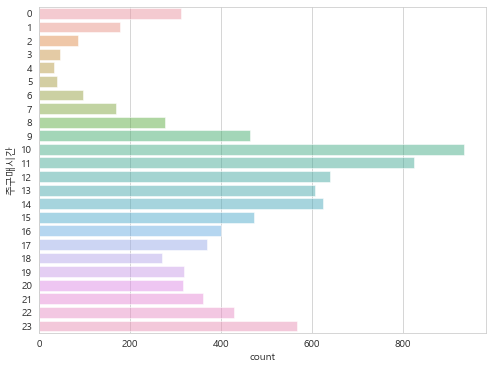

In [56]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y='주구매시간', data=on, alpha=0.5) # 점심전(11시)에 사람이 가장 많음.

In [57]:
df_on['price'] = df_on['buy_am'] / df_on['buy_ct']

price_4q = df_on.groupby('pd_c')['price'].mean().quantile([.25,.5,.75])
price_4q

on = (df_on.groupby('clnt_id')['price']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
features = features.merge(on, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9,0.32,15,0.0
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9,0.16,10,0.0
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0,-0.27,10,0.0
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8,-0.04,10,0.0
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2,0.10,11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0,-0.01,11,0.0
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,0.0
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.0
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.0


In [58]:
on = lg.groupby('clnt_id')['hit_tm'].agg([
    ('주조회시각', lambda x: int(x.str[:2].value_counts().index[0])) 
]).reset_index()
k = features['clnt_id'].reset_index()
w = pd.merge(on,k,on='clnt_id')
del w['index']
features = features.merge(w, how='left'); features
# lg데이터의 hit_tm값에서 시간을 추출하여 '주방문시간'이라는 새로운 피처 생성

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,주조회시각
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9,0.32,15,0.0,17
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9,0.16,10,0.0,16
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0,-0.27,10,0.0,11
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8,-0.04,10,0.0,9
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2,0.10,11,0.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0,-0.01,11,0.0,8
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,0.0,10
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.0,16
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.0,1


In [59]:
on = lg.groupby(['clnt_id','sess_id'])['hit_seq'].count().reset_index().groupby(
    'clnt_id')['hit_seq'].agg([('조회빈도', np.mean)]).reset_index().round(2)
k = features['clnt_id'].reset_index()
w = pd.merge(on,k,on='clnt_id')
del w['index']
features = features.merge(w); features
# lg데이터의 hit_seq값에서 조회일련번호를 추출하여 새로운 '조회빈도'라는 새로운 피처 생성

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,주조회시각,조회빈도
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9,0.32,15,0.0,17,14.91
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9,0.16,10,0.0,16,26.95
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0,-0.27,10,0.0,11,29.80
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8,-0.04,10,0.0,9,9.44
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2,0.10,11,0.0,10,20.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0,-0.01,11,0.0,8,2.20
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,0.0,10,1.00
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.0,16,4.23
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.0,1,1.00


In [60]:
on = lg.groupby('clnt_id')['sess_dt'].agg([('방문횟수', np.size)]).reset_index()
k = features['clnt_id'].reset_index()
w = pd.merge(on,k,on='clnt_id')
del w['index']
features = features.merge(on, how = 'left')
on_features = features
on_features
# lg데이터의 sess_dt값에서 방문일자를 추출하여 '방문횟수'라는 새로운 피처 생성

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,주조회시각,조회빈도,방문횟수
0,39423,433032,77,5624,55600,42,31,16,11,5,0.09,33310.0,5.9,0.32,15,0.0,17,14.91,1267
1,48969,267270,69,3873,25800,41,28,10,6,12,0.00,38181.0,9.9,0.16,10,0.0,16,26.95,593
2,18478,237470,15,15831,65700,13,10,8,5,14,0.00,47494.0,3.0,-0.27,10,0.0,11,29.80,149
3,19163,442090,61,7247,21900,44,26,12,9,6,0.13,49121.0,6.8,-0.04,10,0.0,9,9.44,321
4,48190,149800,21,7133,25800,19,15,7,5,6,0.00,29960.0,4.2,0.10,11,0.0,10,20.09,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,1,42000,42000,1,1,1,1,0,0.00,42000.0,1.0,-0.01,11,0.0,8,2.20,326
8830,53632,77040,1,77040,77040,1,1,1,1,0,0.00,77040.0,1.0,-0.02,10,0.0,10,1.00,1
8831,58443,568000,1,568000,568000,1,1,1,1,0,0.00,568000.0,1.0,0.04,10,1.0,16,4.23,131
8832,21232,362500,1,362500,362500,1,1,1,1,0,0.00,362500.0,1.0,0.04,1,1.0,1,1.00,1


### Online Feature Selection

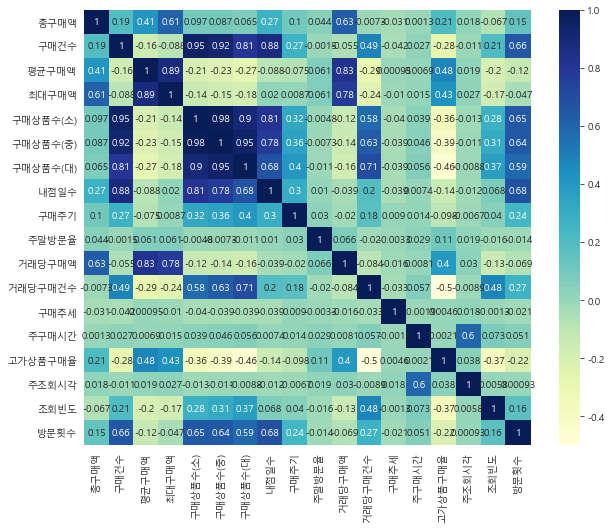

In [61]:
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()
# 상관관계가 높은 열을 살펴보았을 때 구매상품수(소)&(중)&(대), 구매상품수(중)&구매건수, 
# 최대구매액 & 평균구매액 등이 있음을 알 수 있다.

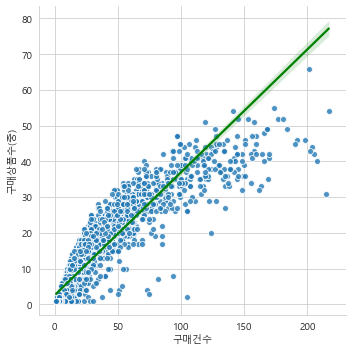

In [62]:
sns.lmplot(x='구매건수', y='구매상품수(중)', data=features, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show() # 구매상품수(중)과 구매건수의 신뢰수준이 높고 양의 상관관계가 매우 높다는 것을 알 수 있다. 

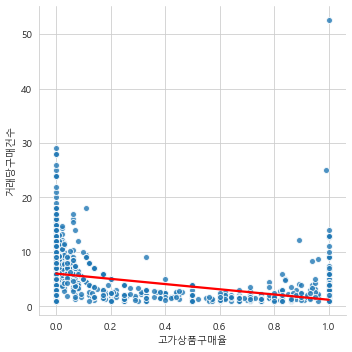

In [63]:
sns.lmplot(x='고가상품구매율', y='거래당구매건수', data=features, 
           line_kws={'color':"red"}, scatter_kws={'edgecolor':"white"})
plt.show() # -0.5 정도의 음의 상관관계가 있으나 유의하지 않다는 것을 알 수 있다.

In [64]:
features = features.drop(columns=['구매건수', '구매상품수(소)', '구매상품수(대)', '최대구매액'])
features # 변수가 유사하면 군집분석이 되지 않으므로 4개의 열을 삭제해준다.

,clnt_id,총구매액,평균구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,주조회시각,조회빈도,방문횟수
0,39423,433032,5624,31,11,5,0.09,33310.0,5.9,0.32,15,0.0,17,14.91,1267
1,48969,267270,3873,28,6,12,0.00,38181.0,9.9,0.16,10,0.0,16,26.95,593
2,18478,237470,15831,10,5,14,0.00,47494.0,3.0,-0.27,10,0.0,11,29.80,149
3,19163,442090,7247,26,9,6,0.13,49121.0,6.8,-0.04,10,0.0,9,9.44,321
4,48190,149800,7133,15,5,6,0.00,29960.0,4.2,0.10,11,0.0,10,20.09,221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,42000,1,1,0,0.00,42000.0,1.0,-0.01,11,0.0,8,2.20,326
8830,53632,77040,77040,1,1,0,0.00,77040.0,1.0,-0.02,10,0.0,10,1.00,1
8831,58443,568000,568000,1,1,0,0.00,568000.0,1.0,0.04,10,1.0,16,4.23,131
8832,21232,362500,362500,1,1,0,0.00,362500.0,1.0,0.04,1,1.0,1,1.00,1


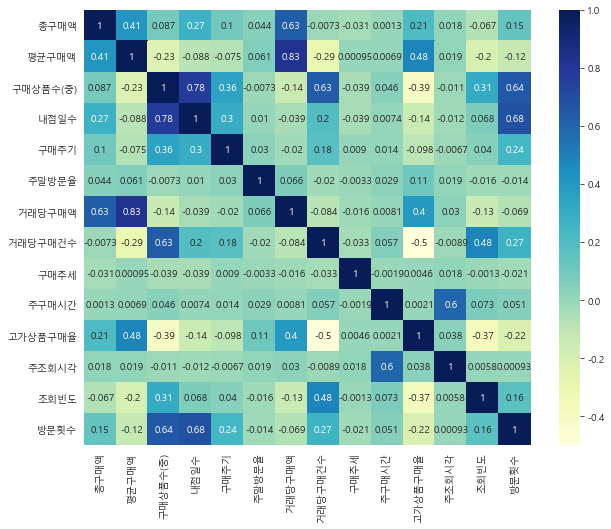

In [65]:
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show() # 다시 상관관계를 보면 0.85가 넘는 상관관계가 없다는 것을 알 수 있다.

In [66]:
features.to_csv('features_on.csv', index=False, encoding='cp949')

### Offline Feature Generation

In [67]:
df_off = df.query('biz_unit == "B01" or biz_unit == "B02" or biz_unit == "B03"')
features = pd.DataFrame({'clnt_id': df_off.clnt_id.unique()}) ;features

,clnt_id
0,34516
1,28454
2,25782
3,65774
4,33801
...,...
7389,47847
7390,64655
7391,41344
7392,36971


In [68]:
off = df_off.groupby('clnt_id')['buy_am'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액
0,34516,808517,97,8335,223000
1,28454,213640,85,2513,12800
2,25782,1233224,228,5409,46800
3,65774,2499406,485,5153,49900
4,33801,935960,208,4500,24000
...,...,...,...,...,...
7389,47847,22900,1,22900,22900
7390,64655,25000,2,12500,15000
7391,41344,99800,1,99800,99800
7392,36971,32000,1,32000,32000


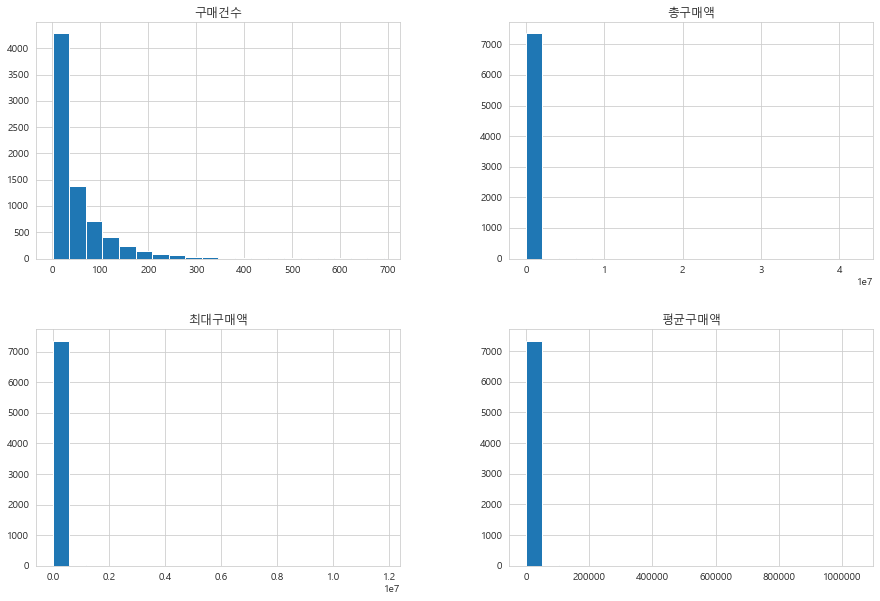

In [69]:
off.iloc[:,1:].hist(bins=20, figsize=(15,10))
plt.show()

In [70]:
def drop_column_level(data):
    c_list = []
    for _, c in data.columns:
        if not c:
            c_list.append(_)
        else:
            c_list.append(c)
    return c_list

In [71]:
off = df_off.groupby('clnt_id').agg({
    'clac_nm3': [('구매상품수(소)', lambda x: x.nunique())],
    'clac_nm2': [('구매상품수(중)', lambda x: x.nunique())],
    'clac_nm1': [('구매상품수(대)', lambda x: x.nunique())]
}).reset_index() 
off.columns = drop_column_level(off)
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대)
0,34516,808517,97,8335,223000,63,45,19
1,28454,213640,85,2513,12800,43,28,17
2,25782,1233224,228,5409,46800,88,61,23
3,65774,2499406,485,5153,49900,156,77,23
4,33801,935960,208,4500,24000,67,43,18
...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1
7390,64655,25000,2,12500,15000,1,1,1
7391,41344,99800,1,99800,99800,1,1,1
7392,36971,32000,1,32000,32000,1,1,1


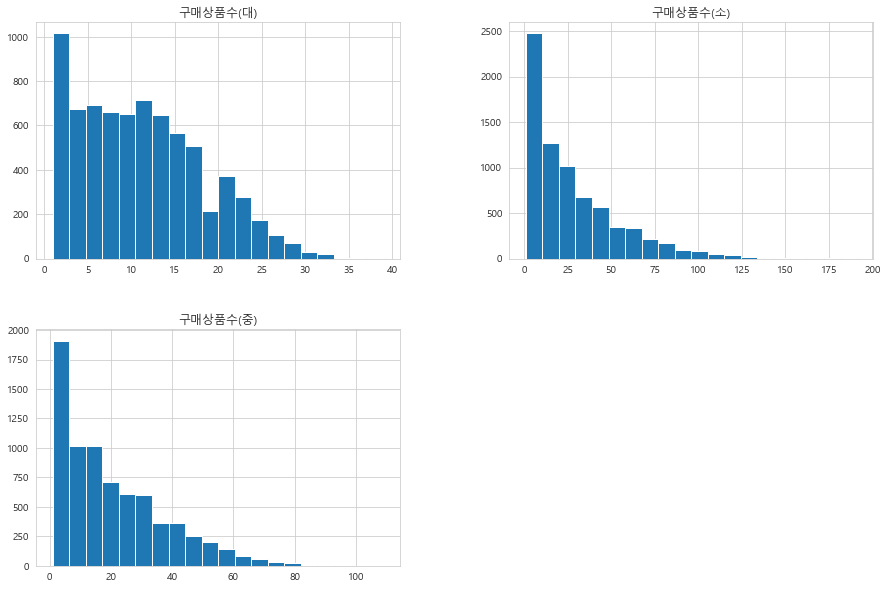

In [72]:
off.iloc[:,1:].hist(bins=20, figsize=(15,10))
plt.show()

In [73]:
off = df_off.groupby('clnt_id')['de_dt'].agg([
    ('내점일수',lambda x: x.nunique()),
    ('구매주기', lambda x: int(((x.max() - x.min()).days) / x.nunique())),
    ('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2))
]).reset_index()
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23
...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00


D:\Anaconda\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


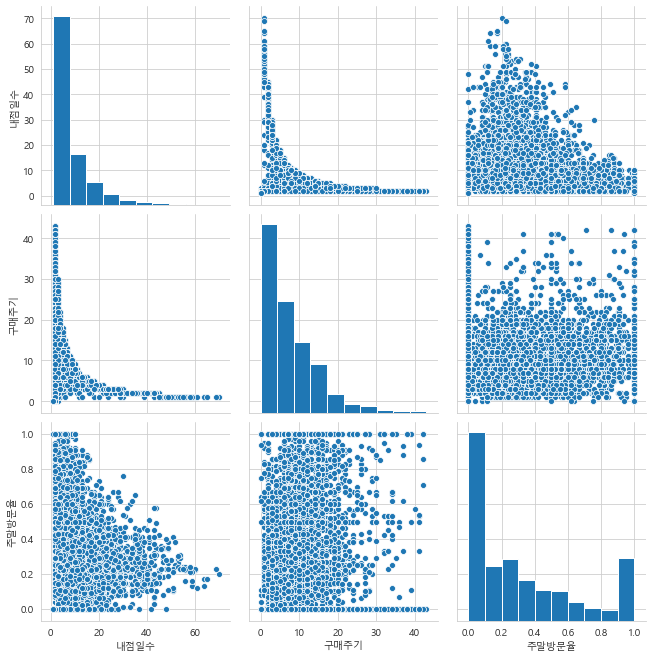

In [74]:
sns.pairplot(data=off.iloc[:,1:], size=3)
plt.show()

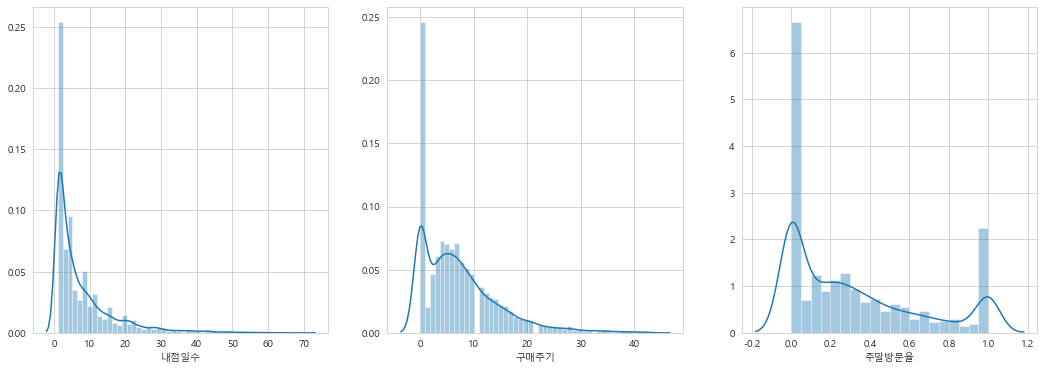

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
sns.distplot(off.내점일수, ax=ax[0])
sns.distplot(off.구매주기, ax=ax[1])
sns.distplot(off.주말방문율, ax=ax[2])
plt.show()

In [76]:
visit_cnt = df_off.groupby('clnt_id')['trans_id'].agg(lambda x: x.nunique())
per_amount = (df_off.groupby('clnt_id')['buy_am'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (df_off.groupby('clnt_id')['buy_am'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})
off = pd.merge(per_amount, per_count, on='clnt_id')
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0


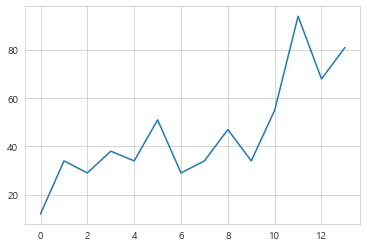

In [77]:
data = [12, 34, 29, 38, 34, 51, 29, 34, 47, 34, 55, 94, 68, 81]
plt.plot(data)
plt.show()

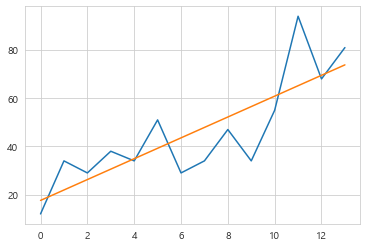

In [78]:
x = np.arange(len(data))
y = np.array(data)
z = np.polyfit(x, y, 1)
z[0], z[1] 

plt.plot(data)
plt.plot([z[0]*i + z[1] for i in range(len(data))])
plt.show() # 전체적으로 우상향, 늘어나고 있음

In [79]:
week_to = df_off.de_dt.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < de_dt <= @week_to')
                      .groupby('clnt_id')['trans_id']
                      .agg([(f'w{10-i}', 'count')])
                      .reset_index())
    week_to = week_from

off = pd.DataFrame({'clnt_id': df_off.clnt_id.unique()})
for w in week_trans[::-1]:
    off = pd.merge(off, w, how='left')
off = off.fillna(0)

off['구매추세'] = off.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
features = features.merge(off.iloc[:,[0,-1]], how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4,-1.16
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5,0.25
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1,1.39
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4,0.88
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7,-0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0,0.00
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0,0.00
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0,0.03
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0,0.01


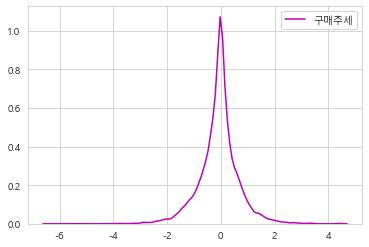

In [80]:
sns.kdeplot(off.구매추세, color='m')
plt.show() 

In [81]:
off = df_off.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4,-1.16,17
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5,0.25,21
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1,1.39,22
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4,0.88,19
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7,-0.41,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0,0.00,16
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0,0.00,18
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0,0.03,18
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0,0.01,16


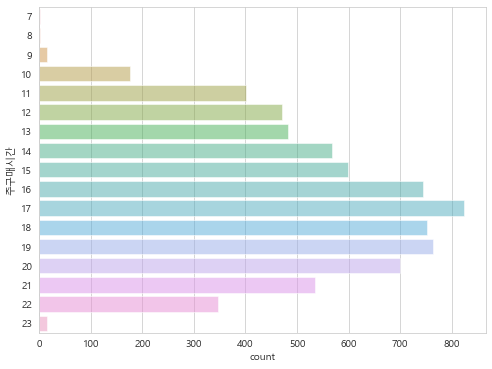

In [82]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y='주구매시간', data=off, alpha=0.5) # 점심전(11시), 저녁전(17시)

In [83]:
df_off['price'] = df_off['buy_am'] / df_off['buy_ct']

price_4q = df_off.groupby('pd_c')['price'].mean().quantile([.25,.5,.75])
price_4q

off = (df_off.groupby('clnt_id')['price']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
features = features.merge(off, how='left'); features

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4,-1.16,17,0.11
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5,0.25,21,0.00
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1,1.39,22,0.05
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4,0.88,19,0.07
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7,-0.41,19,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0,0.00,16,1.00
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0,0.00,18,0.50
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0,0.03,18,1.00
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0,0.01,16,1.00


In [84]:
off = df_off.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4,-1.16,17,0.11
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5,0.25,21,0.00
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1,1.39,22,0.05
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4,0.88,19,0.07
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7,-0.41,19,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0,0.00,16,1.00
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0,0.00,18,0.50
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0,0.03,18,1.00
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0,0.01,16,1.00


In [85]:
off = df_off.groupby('clnt_id')['de_tm'].agg([
    ('주구매시간', lambda x: int(x.str[:2].value_counts().index[0]))
]).reset_index()
features = features.merge(off, how='left'); features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4,-1.16,17,0.11
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5,0.25,21,0.00
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1,1.39,22,0.05
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4,0.88,19,0.07
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7,-0.41,19,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0,0.00,16,1.00
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0,0.00,18,0.50
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0,0.03,18,1.00
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0,0.01,16,1.00


In [86]:
features['off/on'] = df.biz_unit.apply(lambda x: 'online' if x[0]=='A' else 'offline')
features

,clnt_id,총구매액,구매건수,평균구매액,최대구매액,구매상품수(소),구매상품수(중),구매상품수(대),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,off/on
0,34516,808517,97,8335,223000,63,45,19,15,5,0.12,44918.0,5.4,-1.16,17,0.11,online
1,28454,213640,85,2513,12800,43,28,17,9,8,0.33,21364.0,8.5,0.25,21,0.00,online
2,25782,1233224,228,5409,46800,88,61,23,52,1,0.25,11110.0,2.1,1.39,22,0.05,online
3,65774,2499406,485,5153,49900,156,77,23,65,1,0.17,28083.0,5.4,0.88,19,0.07,online
4,33801,935960,208,4500,24000,67,43,18,51,1,0.23,16714.0,3.7,-0.41,19,0.07,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,1,22900,22900,1,1,1,1,0,0.00,22900.0,1.0,0.00,16,1.00,offline
7390,64655,25000,2,12500,15000,1,1,1,1,0,1.00,25000.0,2.0,0.00,18,0.50,offline
7391,41344,99800,1,99800,99800,1,1,1,1,0,0.00,99800.0,1.0,0.03,18,1.00,offline
7392,36971,32000,1,32000,32000,1,1,1,1,0,0.00,32000.0,1.0,0.01,16,1.00,offline


### Offline Feature Selection

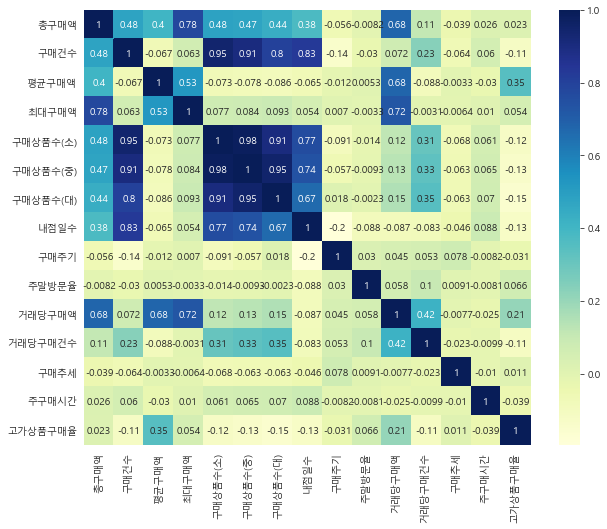

In [87]:
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

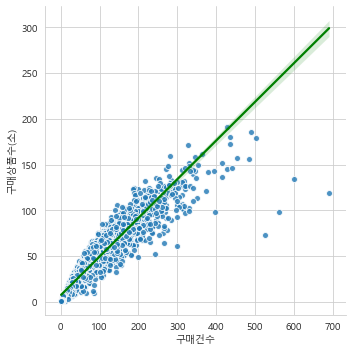

In [88]:
sns.lmplot(x='구매건수', y='구매상품수(소)', data=features, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show()

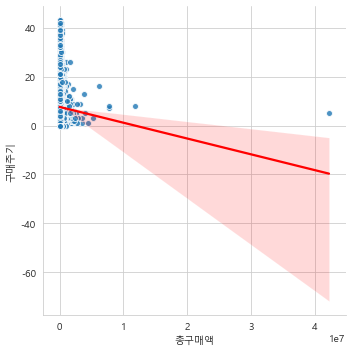

In [89]:
sns.lmplot(x='총구매액', y='구매주기', data=features, 
           line_kws={'color':"red"}, scatter_kws={'edgecolor':"white"})
plt.show() 

In [90]:
features = features.drop(columns=['구매건수', '구매상품수(소)', '구매상품수(대)', '거래당구매액'])
features # 변수가 유사하면 군집분석이 되지 않음. 

,clnt_id,총구매액,평균구매액,최대구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매건수,구매추세,주구매시간,고가상품구매율,off/on
0,34516,808517,8335,223000,45,15,5,0.12,5.4,-1.16,17,0.11,online
1,28454,213640,2513,12800,28,9,8,0.33,8.5,0.25,21,0.00,online
2,25782,1233224,5409,46800,61,52,1,0.25,2.1,1.39,22,0.05,online
3,65774,2499406,5153,49900,77,65,1,0.17,5.4,0.88,19,0.07,online
4,33801,935960,4500,24000,43,51,1,0.23,3.7,-0.41,19,0.07,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,47847,22900,22900,22900,1,1,0,0.00,1.0,0.00,16,1.00,offline
7390,64655,25000,12500,15000,1,1,0,1.00,2.0,0.00,18,0.50,offline
7391,41344,99800,99800,99800,1,1,0,0.00,1.0,0.03,18,1.00,offline
7392,36971,32000,32000,32000,1,1,0,0.00,1.0,0.01,16,1.00,offline


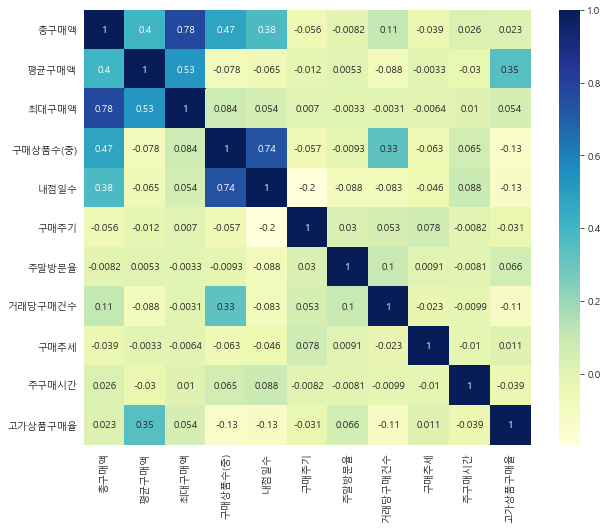

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show() 

In [92]:
features.to_csv('features_off.csv', index=False, encoding='cp949')

## Cluster Analysis

### Online Cluster Analysis

In [93]:
features_on = pd.read_csv('features_on.csv', encoding='cp949')

In [94]:
X = features_on.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) 
X

,총구매액,평균구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,주조회시각,조회빈도,방문횟수
0,3.464140,-0.244572,-0.293103,-0.293277,-0.293329,-0.293372,-0.004334,-0.293321,-0.293370,-0.293242,-0.293372,-0.293225,-0.293243,-0.282378
1,3.439166,-0.256356,-0.310303,-0.310611,-0.310527,-0.310696,0.224993,-0.310557,-0.310693,-0.310555,-0.310696,-0.310471,-0.310317,-0.302376
2,3.400864,-0.089300,-0.338434,-0.338513,-0.338371,-0.338592,0.409299,-0.338544,-0.338596,-0.338434,-0.338592,-0.338419,-0.338122,-0.336245
3,3.452943,-0.241141,-0.302485,-0.302629,-0.302655,-0.302705,0.114587,-0.302648,-0.302706,-0.302621,-0.302706,-0.302629,-0.302626,-0.299979
4,3.403725,-0.155614,-0.333198,-0.333447,-0.333422,-0.333572,0.413887,-0.333467,-0.333570,-0.333298,-0.333572,-0.333323,-0.333071,-0.328058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,1.845179,1.845179,-0.504956,-0.504956,-0.505012,-0.505012,1.845179,-0.504956,-0.505012,-0.504396,-0.505012,-0.504564,-0.504889,-0.486770
8830,1.845200,1.845200,-0.503275,-0.503275,-0.503306,-0.503306,1.845200,-0.503275,-0.503306,-0.503001,-0.503306,-0.503001,-0.503275,-0.503275
8831,1.845200,1.845200,-0.503294,-0.503294,-0.503298,-0.503298,1.845200,-0.503294,-0.503298,-0.503257,-0.503294,-0.503232,-0.503281,-0.502757
8832,1.845200,1.845200,-0.503235,-0.503235,-0.503241,-0.503241,1.845200,-0.503235,-0.503241,-0.503235,-0.503235,-0.503235,-0.503235,-0.503235


In [95]:
wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

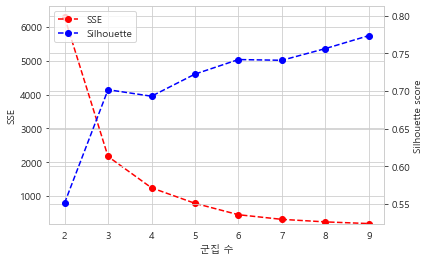

In [96]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show()

In [97]:
!pip install yellowbrick

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


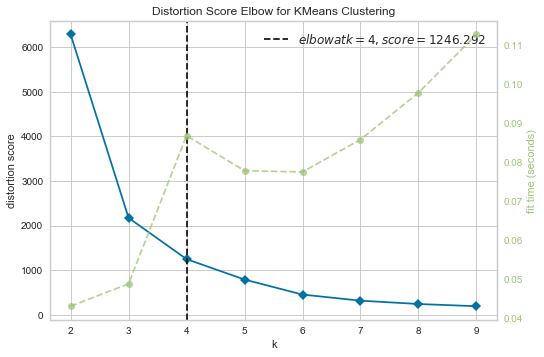

D:\Anaconda\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A33A4DF08>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [98]:
from yellowbrick.cluster.elbow import kelbow_visualizer
kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

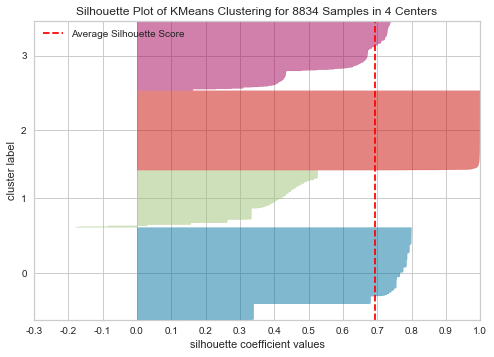

D:\Anaconda\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A34854108>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [99]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(KMeans(4, random_state=0), X, colors='yellowbrick')

In [100]:
# sns 설정이 바뀌었기 때문에 원래로 되돌린다.
sns.reset_defaults()
%matplotlib inline

# Yellowbrick은 영문 폰트를 사용하여 시각화를 하기 떄문에 다시 한글 폰트로 변경해야 한다.
path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Dain':
    rc('font', family='AprwpleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

In [101]:
best_k = 4

In [102]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [103]:
features_on['세그먼트'] = kmeans.labels_
features_on

,clnt_id,총구매액,평균구매액,구매상품수(중),내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,구매추세,주구매시간,고가상품구매율,주조회시각,조회빈도,방문횟수,세그먼트
0,39423,433032,5624,31,11,5,0.09,33310.0,5.9,0.32,15,0.0,17,14.91,1267,3
1,48969,267270,3873,28,6,12,0.00,38181.0,9.9,0.16,10,0.0,16,26.95,593,3
2,18478,237470,15831,10,5,14,0.00,47494.0,3.0,-0.27,10,0.0,11,29.80,149,3
3,19163,442090,7247,26,9,6,0.13,49121.0,6.8,-0.04,10,0.0,9,9.44,321,3
4,48190,149800,7133,15,5,6,0.00,29960.0,4.2,0.10,11,0.0,10,20.09,221,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,18022,42000,42000,1,1,0,0.00,42000.0,1.0,-0.01,11,0.0,8,2.20,326,2
8830,53632,77040,77040,1,1,0,0.00,77040.0,1.0,-0.02,10,0.0,10,1.00,1,2
8831,58443,568000,568000,1,1,0,0.00,568000.0,1.0,0.04,10,1.0,16,4.23,131,2
8832,21232,362500,362500,1,1,0,0.00,362500.0,1.0,0.04,1,1.0,1,1.00,1,2


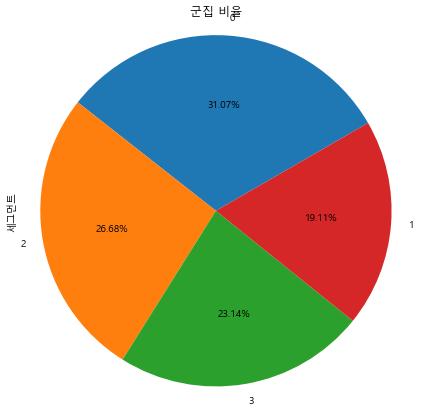

In [104]:
plt.figure(figsize=(6,6))
features_on.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

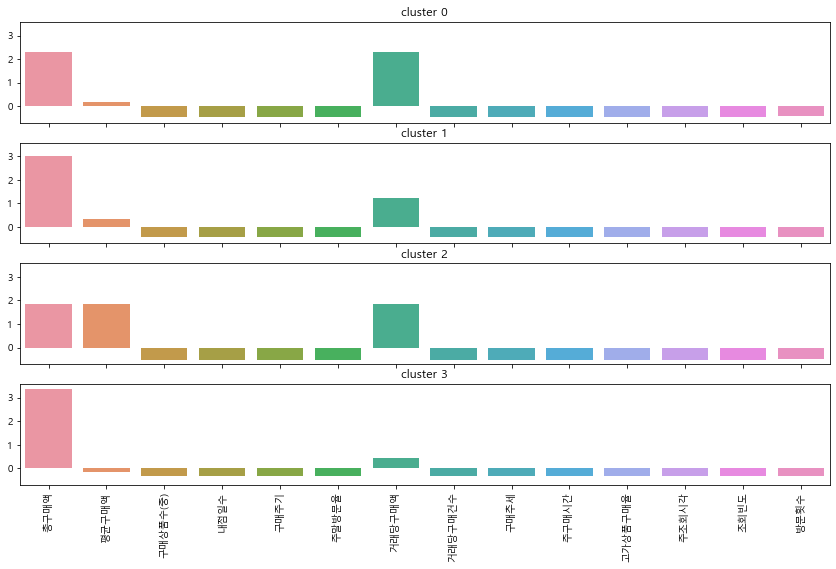

In [105]:
fig, ax = plt.subplots(best_k, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() 

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
    sns.barplot(np.arange(X.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)

In [106]:
rfm_on['세그먼트'] = features_on['세그먼트'] 
rfm_on_aly = rfm_on.groupby('세그먼트')['recency', 'frequency', 'monetary'].mean().reset_index() 

rfm_on_aly['R_level'] = rfm_on_aly.recency.apply(lambda x : "↓" if x <= 40.8499 else "↑")
rfm_on_aly['F_level'] = rfm_on_aly.frequency.apply(lambda x : "↑" if x >= 13.8350 else "↓")
rfm_on_aly['M_level'] = rfm_on_aly.monetary.apply(lambda x : "↑" if x >= 201120 else "↓")
# 각각 rfm의 평균과 비교하여 높고 낮음을 표현해줌.

rfm_on_aly['N'] = rfm_on.groupby('세그먼트')['clnt_id'].count().round(1)
rfm_on_aly

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,세그먼트,recency,frequency,monetary,R_level,F_level,M_level,N
0,0,41.032058,13.998179,188180.614208,↑,↑,↓,2745
1,1,41.234597,13.845379,225213.186019,↑,↑,↑,1688
2,2,40.172253,14.378023,207746.267713,↓,↑,↑,2357
3,3,40.960861,13.118395,183338.409980,↑,↓,↓,2044


In [107]:
rfm_on_aly['순위'] = [3, 1, 2, 4] 
rfm_on_aly['고객분류'] = ['About To Sleep', 'Champions', 'Potential Loyalists', 'Hibernating']
rfm_on_aly

,세그먼트,recency,frequency,monetary,R_level,F_level,M_level,N,순위,고객분류
0,0,41.032058,13.998179,188180.614208,↑,↑,↓,2745,3,About To Sleep
1,1,41.234597,13.845379,225213.186019,↑,↑,↑,1688,1,Champions
2,2,40.172253,14.378023,207746.267713,↓,↑,↑,2357,2,Potential Loyalists
3,3,40.960861,13.118395,183338.409980,↑,↓,↓,2044,4,Hibernating


### Offline Cluster Analysis

In [108]:
features_off = pd.read_csv('features_off.csv', encoding='cp949')

In [109]:
X = features_off.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std(), axis=1) 
X

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [110]:
wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)
    sis = np.append(sis, silhouette_score(X, kmeans.labels_))

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

line1 = ax1.plot(np.arange(2,10), wss, 'ro--', label='SSE')
line2 = ax2.plot(np.arange(2,10), sis, 'bo--', label='Silhouette') 

ax1.set_ylim(wss.min()*0.95, wss.max()*1.05)
ax2.set_ylim(sis.min()*0.95, sis.max()*1.05)

ax1.set_xlabel('군집 수')
ax1.set_ylabel('SSE')
ax2.set_ylabel('Silhouette score')

lines = line1 + line2
labels = [l.get_label() for l in lines]

plt.legend(lines, labels)
plt.show() 

In [149]:
!pip install yellowbrick

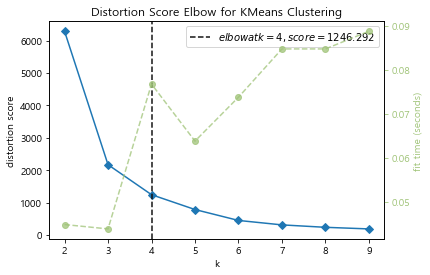

D:\Anaconda\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A4FEDCA08>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

In [150]:
from yellowbrick.cluster.elbow import kelbow_visualizer
kelbow_visualizer(KMeans(random_state=0), X, k=(2,10))

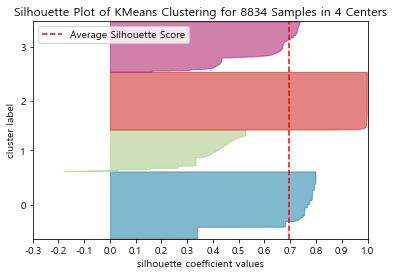

D:\Anaconda\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x0000024A00106D48>,
                     colors='yellowbrick', is_fitted='auto', model=None)

In [151]:
from yellowbrick.cluster import silhouette_visualizer
silhouette_visualizer(KMeans(4, random_state=0), X, colors='yellowbrick')

In [152]:
sns.reset_defaults()
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Dain':
    rc('font', family='AprwpleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...')
rc('axes', unicode_minus=False)  

In [153]:
best_k = 4

In [154]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [155]:
features_off['세그먼트'] = kmeans.labels_
features_off

ValueError: Length of values does not match length of index

In [156]:
plt.figure(figsize=(6,6))
features_off.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal') 
plt.show()

AttributeError: 'DataFrame' object has no attribute '세그먼트'

<Figure size 432x432 with 0 Axes>

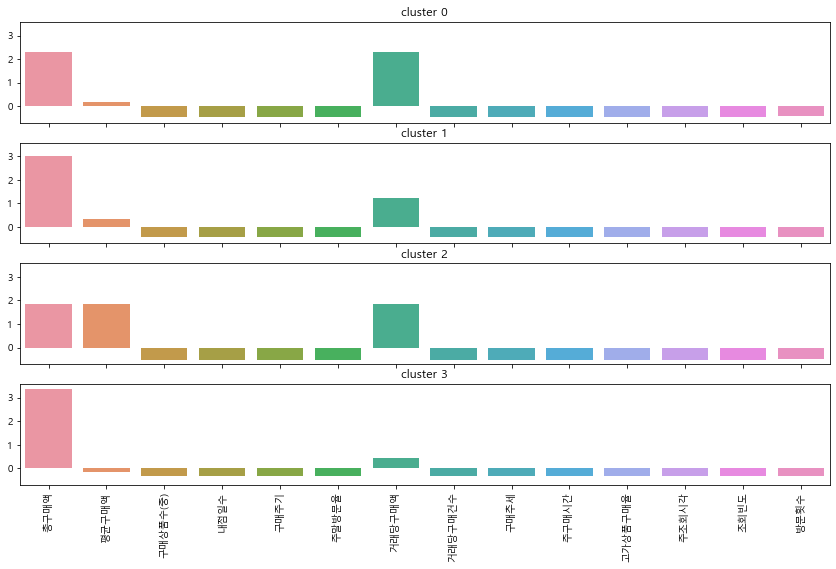

In [157]:
fig, ax = plt.subplots(best_k, 1, figsize=(12,7), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout()

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
    sns.barplot(np.arange(X.columns.size), kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)

In [158]:
rfm_off['세그먼트'] = features_off['세그먼트'] 
rfm_off_aly = rfm_off.groupby('세그먼트')['recency', 'frequency', 'monetary'].mean().reset_index() 

rfm_off_aly['R_level'] = rfm_off_aly.recency.apply(lambda x : "↓" if x <= 23.2891 else "↑")
rfm_off_aly['F_level'] = rfm_off_aly.frequency.apply(lambda x : "↑" if x >= 49.6741 else "↓")
rfm_off_aly['M_level'] = rfm_off_aly.monetary.apply(lambda x : "↑" if x >= 280150 else "↓")
# 각각 rfm의 평균과 비교하여 높고 낮음을 표현해줌.

rfm_off_aly['N'] = rfm_off.groupby('세그먼트')['clnt_id'].count().round(1)
rfm_off_aly

KeyError: '세그먼트'

In [159]:
rfm_off_aly['순위'] = [4, 3, 2, 1] 
rfm_off_aly['고객분류'] = ['Hibernating', 'About To Sleep', 'Potential Loyalists', 'Champions']
rfm_off_aly

NameError: name 'rfm_off_aly' is not defined

## Market Basket Analysis

### Online Basket Analysis

In [125]:
Others = ["Others (Non-Products)", "Other Products", "Gardening / Pets", "Bedding / Handicraft"]
for i in Others:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Others'

In [126]:
Stationary = ['Stationary / Office Supplies', 'Toy', 'Gift Certificates / Cards', 'Books / Records / Instruments']
for i in Stationary:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Stationary'

In [127]:
Funiture_Instrument = ['Tools / Safety Supplies', 'Heating / Cooling Electronics', 'Automotive Products', 'Cell Phones / Accessories', 'Furniture', 'Computers', 'Video / Audio System Electronics']
for i in Funiture_Instrument:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Funiture_Instrument'

In [128]:
Fashion = ["Women's Clothing", "Men's Clothing", 'Underwear / Socks and Hosiery / Homewear', "Kids' Clothing",'Fashion Accessories']
for i in Fashion:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Fashion'

In [129]:
Beauty = ['Personal Care', 'Home Decor / Lighting', 'Cosmetics / Beauty Care']
for i in Beauty:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Beauty'

In [130]:
Health_Sports = ['Health Care', 'Outdoor / Leisure Activities', 'Ball Game / Field Sports', 'Seasonal Sports','Health / Fitness Training', 'Travel / Leisure Services', 'Sport Fashion']
for i in Health_Sports:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Health_Sports'

In [131]:
Household_Goods = ['Detergents / Hygiene Goods', 'Birth Supplies / Baby Products', 'Kitchenware', 
                   'Tableware / Cooking Utensils', 'Cleaning / Laundry / Bathroom Accessories'
                   'Home / Kitchen Appliances', 'Refrigerators and Washing Machines']
for i in Household_Goods:
    df_on.loc[df_on.clac_nm1==i,'clac_nm2'] = 'Household_Goods'

In [132]:
df_on.groupby('clac_nm1')['clac_nm2'].count().sort_values(ascending=False).head(20)

clac_nm1
Vegetables                    15195
Substitute Foods              11415
Meats                         11051
Snack Foods                   10801
Chilled Foods                 10532
Dairy Products                10240
Frozen Foods                   8533
Beverages                      7732
Fruits                         7469
Spices / Seasonings            5003
Detergents / Hygiene Goods     3466
Women's Clothing               2731
Canned / Jarred Foods          2626
Dried Sea Foods                1730
Personal Care                  1725
Fashion Accessories            1313
Sea Foods                      1228
Grains                         1040
Sport Fashion                   972
Coffee / Tea                    945
Name: clac_nm2, dtype: int64

In [133]:
store_data_on = pd.pivot_table(df_on, index='clnt_id', columns='clac_nm2', values='buy_ct', aggfunc=np.size, fill_value=0) \
            .applymap(lambda x: 1 if x>=1 else 0).reset_index() 
transactions_on = store_data_on.iloc[:,1:]
transactions_on

clac_nm2,Air Purifiers / Humidifiers / Dehumidifiers,Australian Imported Beefs,Baby Foods,Baby Snacks,Bakery,Bathroom Fixtures,Beauty,Beauty Electronics,Beer,Biscuits,...,Tea,Tea Drinks,Tofu / Bean Sprouts,Traditional Rice Cakes,US Imported Beefs,Vacuum Cleaners,Vegetable Gift Sets,Water,Western Vegetables,Yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8829,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8830,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
transactions_on.sum().sort_values(ascending=False).head(20)

clac_nm2
Frozen Instant Foods          2617
Instant Noodles               2391
Milk                          2133
Household_Goods               2114
Eggs                          2097
Chilled Instant Foods         2032
Domestic Fruits               1934
Tofu / Bean Sprouts           1831
Fashion                       1686
Snacks                        1568
Beauty                        1523
Fruit Vegetables              1487
Leaf Vegetables               1482
Yogurt                        1476
Retort Pouches                1468
Domestic Porks                1334
Ham and Sausages              1290
Water                         1276
Biscuits                      1241
Fish Cakes and Crab Sticks    1175
dtype: int64

In [135]:
!pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
freq_items_on = apriori(transactions_on, min_support=0.1, use_colnames=True)
freq_items_on.sort_values(by='support', ascending=False)

,support,itemsets
10,0.296242,(Frozen Instant Foods)
15,0.270659,(Instant Noodles)
17,0.241453,(Milk)
13,0.239303,(Household_Goods)
7,0.237378,(Eggs)
...,...,...
73,0.100747,"(Chilled Instant Foods, Frozen Instant Foods, ..."
59,0.100634,"(Fruit Vegetables, Instant Noodles)"
76,0.100634,"(Frozen Instant Foods, Milk, Eggs)"
63,0.100521,"(Instant Noodles, Leaf Vegetables)"


In [136]:
association_rules(freq_items_on, metric="confidence", min_threshold=0.7)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Ham and Sausages),(Frozen Instant Foods),0.146027,0.296242,0.106520,0.729457,2.462372,0.063261,2.601284
1,"(Chilled Instant Foods, Eggs)",(Frozen Instant Foods),0.131424,0.296242,0.100747,0.766581,2.587685,0.061814,3.014994
2,"(Chilled Instant Foods, Instant Noodles)",(Frozen Instant Foods),0.136971,0.296242,0.106860,0.780165,2.633542,0.066283,3.201306
3,"(Instant Noodles, Eggs)",(Frozen Instant Foods),0.143650,0.296242,0.106973,0.744681,2.513760,0.064418,2.756386
4,"(Eggs, Milk)",(Frozen Instant Foods),0.142404,0.296242,0.100634,0.706677,2.385475,0.058448,2.399262
5,"(Instant Noodles, Milk)",(Frozen Instant Foods),0.140140,0.296242,0.102332,0.730210,2.464912,0.060816,2.608541


### Offline Basket Analysis

In [137]:
Others = ["Others (Non-Products)", "Other Products", "Gardening / Pets", "Bedding / Handicraft"]
for i in Others:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Others'

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [138]:
Stationary = ['Stationary / Office Supplies', 'Toy', 'Gift Certificates / Cards', 'Books / Records / Instruments']
for i in Stationary:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Stationary'

In [139]:
Funiture_Instrument = ['Tools / Safety Supplies', 'Heating / Cooling Electronics', 'Automotive Products', 'Cell Phones / Accessories', 'Furniture', 'Computers', 'Video / Audio System Electronics']
for i in Funiture_Instrument:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Funiture_Instrument'

In [140]:
Fashion = ["Women's Clothing", "Men's Clothing", 'Underwear / Socks and Hosiery / Homewear', "Kids' Clothing",'Fashion Accessories']
for i in Fashion:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Fashion'

In [141]:
Beauty = ['Personal Care', 'Home Decor / Lighting', 'Cosmetics / Beauty Care']
for i in Beauty:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Beauty'

In [142]:
Health_Sports = ['Health Care', 'Outdoor / Leisure Activities', 'Ball Game / Field Sports', 'Seasonal Sports','Health / Fitness Training', 'Travel / Leisure Services', 'Sport Fashion']
for i in Health_Sports:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Health_Sports'

In [143]:
Household_Goods = ['Detergents / Hygiene Goods', 'Birth Supplies / Baby Products', 'Kitchenware', 
                   'Tableware / Cooking Utensils', 'Cleaning / Laundry / Bathroom Accessories'
                   'Home / Kitchen Appliances', 'Refrigerators and Washing Machines']
for i in Household_Goods:
    df_off.loc[df_off.clac_nm1==i,'clac_nm2'] = 'Household_Goods'

In [144]:
df_off.groupby('clac_nm1')['clac_nm2'].count().sort_values(ascending=False).head(20)

clac_nm1
Vegetables                                   42397
Snack Foods                                  38473
Dairy Products                               28818
Chilled Foods                                25739
Meats                                        25528
Substitute Foods                             22535
Fruits                                       20983
Beverages                                    20982
Liquors / Alcoholic Beverages                16237
Frozen Foods                                 15395
Cleaning / Laundry / Bathroom Accessories    11804
Spices / Seasonings                          11587
Kitchenware                                  11307
Sea Foods                                     7702
Detergents / Hygiene Goods                    5739
Personal Care                                 5639
Tenants / Restaurants                         5609
Dried Sea Foods                               5609
Cooked Foods                                  5457
Cosmetics / Beauty Car

In [145]:
store_data_off = pd.pivot_table(df_off, index='clnt_id', columns='clac_nm2', values='buy_ct', aggfunc=np.size, fill_value=0) \
            .applymap(lambda x: 1 if x>=1 else 0).reset_index() 
transactions_off = store_data_off.iloc[:,1:]
transactions_off

clac_nm2,Alcoholic Beverage Sets,Australian Imported Beefs,Baby Foods,Baby Snacks,Bakery,Bathroom Fixtures,Beauty,Beauty Electronics,Beer,Biscuits,...,Tea Drinks,Tofu / Bean Sprouts,Traditional Liquors,Traditional Rice Cakes,US Imported Beefs,Vegetable Gift Sets,Water,Western Vegetables,Wine,Yogurt
0,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7389,0,0,0,0,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,1
7390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7391,0,0,0,0,0,0,1,0,1,1,...,0,1,0,0,0,0,1,0,0,1
7392,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [146]:
transactions_off.sum().sort_values(ascending=False).head(20)

clac_nm2
Household_Goods               3973
Snacks                        3905
Domestic Fruits               3433
Beauty                        3315
Milk                          3298
Cleaning Accessories          3170
Tofu / Bean Sprouts           3113
Yogurt                        3097
Leaf Vegetables               2993
Instant Noodles               2929
Imported Fruits               2859
Fruit Vegetables              2822
Biscuits                      2811
Eggs                          2576
Ham and Sausages              2501
Beer                          2388
Fish Cakes and Crab Sticks    2378
Chilled Instant Foods         2308
Domestic Porks                2238
Soft Drinks                   2116
dtype: int64

In [147]:
!pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
freq_items_off = apriori(transactions_off, min_support=0.2, use_colnames=True)
freq_items_off.sort_values(by='support', ascending=False)

,support,itemsets
17,0.537328,(Household_Goods)
32,0.528131,(Snacks)
8,0.464295,(Domestic Fruits)
0,0.448336,(Beauty)
23,0.446037,(Milk)
...,...,...
198,0.200298,"(Instant Noodles, Snacks, Biscuits)"
247,0.200298,"(Snacks, Tofu / Bean Sprouts, Imported Fruits)"
100,0.200162,"(Root Vegetables, Domestic Fruits)"
195,0.200027,"(Beauty, Snacks, Milk)"


In [148]:
association_rules(freq_items_off, metric="confidence", min_threshold=0.8)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Biscuits),(Snacks),0.380173,0.528131,0.314850,0.828175,1.568124,0.114069,2.746219
1,(Candies),(Snacks),0.248850,0.528131,0.205843,0.827174,1.566229,0.074417,2.730312
2,"(Beauty, Domestic Fruits)",(Household_Goods),0.259400,0.537328,0.214633,0.827424,1.539888,0.075251,2.680984
3,"(Beauty, Milk)",(Household_Goods),0.248715,0.537328,0.208006,0.836324,1.556451,0.074365,2.826760
4,"(Beauty, Snacks)",(Household_Goods),0.289965,0.537328,0.235867,0.813433,1.513849,0.080061,2.479924
...,...,...,...,...,...,...,...,...,...
16,"(Ham and Sausages, Household_Goods)",(Snacks),0.249797,0.528131,0.204896,0.820249,1.553117,0.072970,2.625127
17,"(Instant Noodles, Household_Goods)",(Snacks),0.289694,0.528131,0.233973,0.807656,1.529273,0.080977,2.453261
18,"(Tofu / Bean Sprouts, Imported Fruits)",(Snacks),0.250203,0.528131,0.200298,0.800541,1.515799,0.068158,2.365739
19,"(Instant Noodles, Milk)",(Snacks),0.254936,0.528131,0.206384,0.809549,1.532857,0.071744,2.477641


## Recommend System

### Online Recommend System

In [111]:
ratings_matrix = pd.pivot_table(df_on, index='clnt_id', columns='clac_nm3', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

print(ratings_matrix.shape)
ratings_matrix

(8834, 1056)


clac_nm3,Accessory Bags,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bed Fillings,Adults' Bedding Sets,Adults' Duvet / Duvet Cover,Adults' Korean Style Mattress / Covers,Adults' Mattress Cover,Adults' Pads / Bed Spread,...,Yellow Corvina Fish,Yellow Corvina Fish Gift Sets,Yoga / Pilates Clothing,Yoga Mats / Exercise Mats,Yoghurts / Chunggukjang Makers,Yogurt Drinks,Young Pumpkins,Young Radishes,Zipper Poly Bags / Plastic Bags,kelp
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

np.fill_diagonal(user_sim.values, 2)
print(user_sim.shape)
user_sim

(8834, 8834)


clnt_id,2,9,23,24,38,40,45,49,54,57,...,72331,72333,72340,72342,72356,72373,72400,72410,72423,72424
clnt_id,,,,,,,,,,,,,,,,,,,,,
2,2.000000,0.109109,0.0,0.113228,0.0,0.0,0.0,0.151911,0.0,0.0,...,0.0,0.144338,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
9,0.109109,2.000000,0.0,0.370625,0.0,0.0,0.0,0.165748,0.0,0.0,...,0.0,0.283473,0.000000,0.0,0.000000,0.0,0.0,0.267261,0.0,0.0
23,0.000000,0.000000,2.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
24,0.113228,0.370625,0.0,2.000000,0.0,0.0,0.0,0.206406,0.0,0.0,...,0.0,0.294174,0.248069,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
38,0.000000,0.000000,0.0,0.000000,2.0,0.0,0.0,0.055470,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.129099,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72373,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.102062,2.0,0.0,0.000000,0.0,0.0
72400,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.204124,0.0,2.0,0.000000,0.0,0.0
72410,0.000000,0.267261,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,2.000000,0.0,0.0


In [113]:
# Id=2인 고객과 유사도가 높은 상위 K명 리스트
user_sim.loc[2].sort_values(ascending=False)[1:10]

clnt_id
44452    0.707107
63702    0.471405
66283    0.471405
22833    0.462910
53058    0.462910
55422    0.408248
59881    0.408248
23328    0.408248
8183     0.408248
Name: 2, dtype: float64

In [114]:
K = 10
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,10
clnt_id,,,,,,,,,,,
2,2,44452,63702,66283,22833,53058,55422,59881,23328,8183,5153
9,9,68543,14579,7962,67726,66745,8223,35718,44507,14310,48218
23,23,55354,15202,13473,51913,46723,25548,25609,25602,25599,25598
24,24,67553,70174,57427,39801,40335,26337,10126,57210,46922,38885
38,38,42011,32150,17907,5763,9497,14387,13056,70557,70503,56830
...,...,...,...,...,...,...,...,...,...,...,...
72373,72373,45612,52181,54738,42644,47804,28773,8120,65653,34125,42509
72400,72400,61950,50120,14381,69550,57771,37241,4052,44180,36121,23402
72410,72410,34991,5949,18997,24879,41000,53725,53049,31009,42580,12013


In [115]:
N = 10
purchased_list = df_on.groupby('clnt_id')['clac_nm3'].unique()
purchased_list

clnt_id
2        [Ramens, Canned Vegetable Foods, Coffee Drinks...
9        [Functional Milk, Ramens, Fish Cakes, Other Ko...
23                            [Infant / Toddlers' Dresses]
24       [Functional Milk, Ramens, Chicken Eggs, Rice, ...
38       [Domestic Beefs - Sirloins, Other Nuts, Chicki...
                               ...                        
72373    [Canned Fruit Foods, Rags, Creams / Balms / Oi...
72400     [Hair Shampoos, Special Offer Sales / B2B Sales]
72410                                             [Cheese]
72423                                        [Cell Phones]
72424    [Domestic Porks - Shoulder Butts, Imported Por...
Name: clac_nm3, Length: 8834, dtype: object

In [116]:
def top_n(x, n):
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    return [item for item in candidate if item not in purchased][:n]

recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,2,"[Ham, Frozen Korean Pancakes, Bibim Ramens, Wa..."
1,9,"[Soy Sauces, Spoon Type Yogurts, Soybean Sprou..."
2,23,"[Fresh Milk, Infant / Toddlers' Pants, Women's..."
3,24,"[Bibim Ramens, Frozen Korean Pancakes, Frozen ..."
4,38,"[Fruit Tea, Frozen Vegetables, Fruit / Vegetab..."
...,...,...
8829,72373,"[Makeup Sets, Men's Panties, Women's Running /..."
8830,72400,"[kelp, Frozen Vegetables, Garlic, Functional M..."
8831,72410,"[Frozen Tteokbokkis, Grapes, Potato Snacks, Pa..."
8832,72423,"[Potato Snacks, Chicken Eggs, Crackers, Other ..."


In [117]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=[2]).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == 2').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Ramens,Ham
1,Canned Vegetable Foods,Frozen Korean Pancakes
2,Coffee Drinks,Bibim Ramens
3,Fried Tofu,Watermelons
4,Crab Sticks,Water
5,Cream and Condensed milk,Sausages
6,NaN,Pasta Sauces
7,NaN,Soybean Sprouts
8,NaN,Chilled Rice Cakes
9,NaN,Functional Milk


### Offline Recommend System

In [118]:
ratings_matrix = pd.pivot_table(df_off, index='clnt_id', columns='clac_nm3', values='pd_c', 
                                aggfunc=lambda x: 1 if len(x) >= 1 else 0, fill_value=0)

print(ratings_matrix.shape)
ratings_matrix

(7394, 1389)


clac_nm3,,Accessory Bags,Accident Prevention Equipment,Adhesive Tapes,Adhesives,Adult's Bed Covers and Skirts,Adult's Diapers,Adult's Disposable Briefes,Adults' Bedding Sets,Adults' Blankets,...,Yellow Corvina Fish Gift Sets,Yoga / Pilates Clothing,Yoga Mats / Exercise Mats,Yogurt Drinks,Young Pumpkins,Young Radishes,Yuzus / Quinces,Zipper Poly Bags / Plastic Bags,kelp,life Vests / Safety Accessories
clnt_id,,,,,,,,,,,,,,,,,,,,,
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
72356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
72410,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(ratings_matrix, ratings_matrix)
user_sim = pd.DataFrame(user_sim, ratings_matrix.index, ratings_matrix.index)

np.fill_diagonal(user_sim.values, 2)
print(user_sim.shape)
user_sim

(7394, 7394)


clnt_id,9,12,20,23,24,29,41,43,45,49,...,72284,72297,72301,72321,72333,72340,72356,72410,72423,72424
clnt_id,,,,,,,,,,,,,,,,,,,,,
9,2.000000,0.0,0.000000,0.139771,0.0,0.202610,0.172516,0.145986,0.0,0.0,...,0.045502,0.089087,0.0,0.267261,0.072739,0.211702,0.178174,0.174574,0.0,0.101015
12,0.000000,2.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
20,0.000000,0.0,2.000000,0.000000,0.0,0.185695,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.154303
23,0.139771,0.0,0.000000,2.000000,0.0,0.208145,0.050637,0.227640,0.0,0.0,...,0.200334,0.065372,0.0,0.196116,0.160128,0.135929,0.065372,0.128103,0.0,0.172958
24,0.000000,0.0,0.000000,0.000000,2.0,0.000000,0.000000,0.083624,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72340,0.211702,0.0,0.000000,0.135929,0.0,0.360302,0.268438,0.314369,0.0,0.0,...,0.202289,0.099015,0.0,0.148522,0.161690,2.000000,0.049507,0.121268,0.0,0.224544
72356,0.178174,0.0,0.000000,0.065372,0.0,0.000000,0.000000,0.034139,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.049507,2.000000,0.000000,0.0,0.062994
72410,0.174574,0.0,0.000000,0.128103,0.0,0.222834,0.189737,0.301047,0.0,0.0,...,0.125109,0.163299,0.0,0.163299,0.200000,0.121268,0.000000,2.000000,0.0,0.246885


In [120]:
# Id=2인 고객과 유사도가 높은 상위 K명 리스트
user_sim.loc[9].sort_values(ascending=False)[1:10]

clnt_id
17920    0.408248
56834    0.400892
10800    0.379536
9110     0.363137
55715    0.356348
71940    0.341565
39810    0.335968
17506    0.333333
47928    0.329914
Name: 9, dtype: float64

In [121]:
K = 10
knn = user_sim.apply(lambda x,k: x.sort_values(ascending=False).index[:k+1], args=(K,)).T
knn

,0,1,2,3,4,5,6,7,8,9,10
clnt_id,,,,,,,,,,,
9,9,17920,56834,10800,9110,55715,71940,39810,17506,47928,54651
12,12,64406,36089,395,909,49148,67955,53656,51950,58558,25451
20,20,29642,15985,1261,33286,1230,45034,1853,36346,53569,28215
23,23,1316,62234,70144,61990,69697,66940,18829,35999,22401,33794
24,24,63085,28210,26157,64139,15237,25642,41795,37424,22278,6706
...,...,...,...,...,...,...,...,...,...,...,...
72340,72340,39812,4581,44407,25782,5843,30359,52715,64651,52111,29113
72356,72356,48886,48379,13608,50944,24621,30889,19158,12488,56370,58452
72410,72410,69730,36518,45171,39811,39020,3425,53780,58764,38264,58044


In [122]:
N = 10
purchased_list = df_off.groupby('clnt_id')['clac_nm3'].unique()
purchased_list

clnt_id
9        [Young Pumpkins, Bananas, Saesongi Mushrooms, ...
12                                               [Peaches]
20                                        [Packged Kimchi]
23       [Chilled Noodles, Onions, Domestic Beefs - Rou...
24                                            [Sandwiches]
                               ...                        
72340    [Seasoned Sliced Dried Lavers, Chickins for Br...
72356    [Domestic Beefs - Rounds, Ciders, Korean Seafo...
72410    [Functional Milk, Bananas, Fish Cakes, Chicken...
72423                                 [Beauty Supplements]
72424    [Cookies, Packged Kimchi, Ramens, Fish Cakes, ...
Name: clac_nm3, Length: 7394, dtype: object

In [123]:
def top_n(x, n):
    purchased = purchased_list.filter(items=[x[0]]).iloc[0]
    candidate = ratings_matrix.filter(items=x[1:], axis=0).sum().sort_values(ascending=False).index.to_list()
    return [item for item in candidate if item not in purchased][:n]

recommend_list = knn.apply(top_n, args=(N,), axis=1).reset_index().rename(columns={0:'recommend_items'})
recommend_list

,clnt_id,recommend_items
0,9,"[Trash Bags, Cookie Cakes, Ramens, Imported Be..."
1,12,"[Dried Anchovies For Parching And Boiling, Fit..."
2,20,"[Fixed-price Living Products, Chilled Noodles,..."
3,23,"[Tofu, Sausages, Ramens, Flavored Milk, Genera..."
4,24,"[Triangle Shaped Gimbabs, Trash Bags, Bananas,..."
...,...,...
7389,72340,"[Spoon Type Yogurts, Fish Cakes, Chilled Noodl..."
7390,72356,"[Soft Drink Mixes, Bananas, Ssamjang, Tofu, On..."
7391,72410,"[Fresh Milk, Trash Bags, Cookies, Cheese, Fixe..."
7392,72423,"[Trash Bags, General Snacks, Sanitary Pads, Ra..."


In [124]:
pd.concat([pd.DataFrame({'purchased': purchased_list.filter(items=[9]).iloc[0]}),
           pd.DataFrame({'recommend': recommend_list.query('clnt_id == 9').recommend_items.iloc[0]})],
          ignore_index=False, axis=1)

,purchased,recommend
0,Young Pumpkins,Trash Bags
1,Bananas,Cookie Cakes
2,Saesongi Mushrooms,Ramens
3,Tofu,Imported Beer
4,Kiwi,Peppers
...,...,...
16,White Wine,NaN
17,US Imported Beefs - Shoulders,NaN
18,Plain Breads,NaN
19,Other Oriental Medicine Ingredients,NaN


# END